# VQE

## Finding eigenvalues

### Initialise

In [1]:
#%%writefile '02_Eigenvalues.py'
# Import NumPy
import numpy as np
# Import scipy optimization
import scipy as sp
# Import mathplotlib
import matplotlib.pyplot as plt
# Import pandas
import pandas as pd
# Import Qiskit
from qiskit.algorithms.optimizers import SPSA, ADAM, COBYLA,\
                                         GradientDescent
from qiskit.algorithms import VQE, NumPyEigensolver
from qiskit.opflow import I, X, Y, Z, H, CX, Zero, One, ListOp,\
                          PauliExpectation, PauliTrotterEvolution,\
                          CircuitSampler, MatrixEvolution, Suzuki,\
                          StateFn, Plus, Minus, DictStateFn,\
                          VectorStateFn, CircuitStateFn, AerPauliExpectation,\
                          OperatorStateFn, MatrixOp, ExpectationFactory
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit import Aer, execute
from qiskit.circuit.library import RealAmplitudes, TwoLocal
from qiskit.circuit import ParameterVector
from qiskit import QuantumCircuit,  ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.quantum_info.operators import Operator, Pauli
from scipy.optimize import minimize
from qiskit.providers.aer import AerError
from qiskit.providers.aer.noise import NoiseModel

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Sans Serif"],
})

In [19]:
def pd_process(data_df):
    res_proc = pd.DataFrame({'mean': data_df.mean(axis = 1),\
                           'std': data_df.std(axis = 1),\
                           'sem': data_df.sem(axis = 1)})
    return res_proc

### Choose simulator

In [58]:
# Initialize a GPU backend
try:
    backend = Aer.get_backend('aer_simulator')
    backend.set_options(method="density_matrix", device='GPU')
    print('Successfully set GPU simulator')
except AerError as e:
    backend = Aer.get_backend('aer_simulator')
    print('Error initialising GPU, using CPU simulator instead')

Successfully set GPU simulator


In [3]:
backend = Aer.get_backend('qasm_simulator')
#backend.set_options(method="statevector", device='GPU')

In [4]:
print(backend)

qasm_simulator


In [11]:
# The Hamiltonian matrix for finding the eigenvalues
a = -0.5 ; b = 0.75 ; c = 2
H3 = np.zeros((3,3)) ; H3[1,1] = b ; H3[2,2] = -c/2+b
H3[0,2] = a ; H3[1,2] = a ; H3[2,0] = a ; H3[2,1] = a
H4=np.zeros((4,4)) ; H4[0:3, 0:3] = H3
eigenvalues_c, eigenvectors_c = np.linalg.eig(H3)
print("Standard Eigenvalues: ", eigenvalues_c)
H_mat=MatrixOp(H4) ; H_op = H_mat.to_pauli_op()

Standard Eigenvalues:  [-0.75  0.25  1.  ]


In [25]:
#backend = Aer.get_backend('aer_simulator')
#qinstance = QuantumInstance(backend, shots = 300, seed_simulator=2, seed_transpiler=2)
qinstance = QuantumInstance(backend, shots = 300)

In [33]:
qinstance = QuantumInstance(backend, shots = 300)
ansatz = RealAmplitudes(2, reps=1)
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(tol=1e-06), quantum_instance=qinstance)
result = vqe.compute_minimum_eigenvalue(H_op)
print(result.eigenvalue)

(-0.7650000000000001+0j)


In [30]:
qinstance = QuantumInstance(backend, shots = 400, seed_simulator=2)
ansatz = RealAmplitudes(2, reps=1)
vqe = VQE(ansatz=ansatz, optimizer=GradientDescent(maxiter=100, learning_rate=0.1, tol=1e-07,perturbation=0.009), quantum_instance=qinstance)
result = vqe.compute_minimum_eigenvalue(H_op)
print(result.eigenvalue)

(-0.741875+0j)


In [53]:
p = ParameterVector('p', 4) 
hamiltonian_op = H_op
shots = 300
NQUBITS = 2
# Create quantum circuit
QC = QuantumCircuit(NQUBITS)
for it in range(0,2):
    QC.rx(p[it], it)
for it in range(0,2):
    QC.ry(p[it+2], it)
QC.cx(0, 1)
#QC.draw()

#qinstance = QuantumInstance(backend, shots = 400, seed_simulator=2)
for _ in range(5):
    qinstance_tmp = QuantumInstance(backend, shots = SHOTS)
    vqe_tmp = VQE(ansatz=QC, initial_point = [1.0, 1.0, 1.0, 1.0],\
                  optimizer=GradientDescent(maxiter=100, learning_rate=0.3,\
                  tol=0.09,perturbation=0.05), quantum_instance=qinstance_tmp,\
                  expectation=PauliExpectation())
    result_tmp = vqe_tmp.compute_minimum_eigenvalue(H_op)
    print(result_tmp.eigenvalue.real, result_tmp.cost_function_evals)

-0.6084999999999999 100
-0.6337499999999999 100
-0.56325 100
-0.6775 100
-0.68375 100


In [55]:
p = ParameterVector('p', 4) 
hamiltonian_op = H_op
shots = 300
NQUBITS = 2
# Create quantum circuit
QC = QuantumCircuit(NQUBITS)
for it in range(0,2):
    QC.rx(p[it], it)
for it in range(0,2):
    QC.ry(p[it+2], it)
QC.cx(0, 1)
#QC.draw()

#qinstance = QuantumInstance(backend, shots = 400, seed_simulator=2)
for _ in range(5):
    qinstance_tmp = QuantumInstance(backend, shots = SHOTS)
    vqe_tmp = VQE(ansatz=QC, initial_point = [1.0, 1.0, 1.0, 1.0],\
                  optimizer=SPSA(maxiter=100), quantum_instance=qinstance_tmp,\
                  expectation=PauliExpectation())
    result_tmp = vqe_tmp.compute_minimum_eigenvalue(H_op)
    print(result_tmp.eigenvalue.real, result_tmp.cost_function_evals)

-0.6924999999999999 200
-0.6737500000000001 200
-0.7175 200
-0.74875 200
-0.7375 200


In [14]:
qinstance = QuantumInstance(backend, shots = 400, seed_simulator=2)
ansatz = TwoLocal(2, ['rx','ry'], 'cx', 'linear', reps=1, insert_barriers=True)
vqe = VQE(ansatz=ansatz, optimizer=COBYLA(tol=1e-06), quantum_instance=qinstance)
result = vqe.compute_minimum_eigenvalue(H_op)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 103,
    'eigenstate': {   '00': 0.5220153254455275,
                      '01': 0.229128784747792,
                      '10': 0.8185352771872451,
                      '11': 0.07071067811865475},
    'eigenvalue': (-0.7450000000000001+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[1]): 3.632858325432645,
                              ParameterVectorElement(θ[0]): -5.414146091638018,
                              ParameterVectorElement(θ[6]): -2.4262372015774316,
                              ParameterVectorElement(θ[7]): -2.7218899561880967,
                              ParameterVectorElement(θ[3]): -4.568018017191861,
                              ParameterVectorElement(θ[5]): -0.07871808003427884,
                              ParameterVectorElement(θ[2]): 3.8729269595977693,
                              ParameterVectorElement(θ[4]): -1.1810724867849793},
    'optimal_point': array([-5.41414609,  3.6328

In [38]:
QGD_results = []
QGD_nfev = []
for SHOTS in range(200, 1040, 80):
    res_tmp = []
    nfev_tmp = []
    for it in range(10): 
        print('-------------- SHOTS =',SHOTS,' it=',it,'--------------')
        qinstance_tmp = QuantumInstance(backend, shots = SHOTS)
        vqe_tmp = VQE(ansatz=QC, initial_point = [1.0, 1.0, 1.0, 1.0],\
                      optimizer=GradientDescent(maxiter=100, learning_rate=0.3,\
                      tol=0.01,perturbation=0.05), quantum_instance=qinstance_tmp,\
                      expectation=PauliExpectation())
        result_tmp = vqe_tmp.compute_minimum_eigenvalue(H_op)
        res_tmp.append(result_tmp.eigenvalue.real)
        nfev_tmp.append(result_tmp.cost_function_evals)
    QGD_results.append(res_tmp)
    QGD_nfev.append(nfev_tmp)
QGD_results_df = pd.DataFrame(QGD_results)
QGD_nfev_df = pd.DataFrame(QGD_nfev)
QGD_results_df.to_csv("QGD_results_df.csv", index=False)
QGD_nfev_df.to_csv("QGD_nfev_df.csv", index=False)
QGD_res_proc = pd_process(QGD_results_df)
QGD_nfev_proc = pd_process(QGD_nfev_df)

-------------- SHOTS = 200  it= 0 --------------
-------------- SHOTS = 200  it= 1 --------------
-------------- SHOTS = 200  it= 2 --------------
-------------- SHOTS = 200  it= 3 --------------
-------------- SHOTS = 200  it= 4 --------------
-------------- SHOTS = 200  it= 5 --------------
-------------- SHOTS = 200  it= 6 --------------
-------------- SHOTS = 200  it= 7 --------------
-------------- SHOTS = 200  it= 8 --------------
-------------- SHOTS = 200  it= 9 --------------
-------------- SHOTS = 280  it= 0 --------------
-------------- SHOTS = 280  it= 1 --------------
-------------- SHOTS = 280  it= 2 --------------
-------------- SHOTS = 280  it= 3 --------------
-------------- SHOTS = 280  it= 4 --------------
-------------- SHOTS = 280  it= 5 --------------
-------------- SHOTS = 280  it= 6 --------------
-------------- SHOTS = 280  it= 7 --------------
-------------- SHOTS = 280  it= 8 --------------
-------------- SHOTS = 280  it= 9 --------------
-------------- SHOTS

In [48]:
x_coor = []
for x in (range(200,1040,80)):
    x_coor.append(x)
x_coor = pd.Series(x_coor)

Text(0, 0.5, 'Eigenvalue approximation')

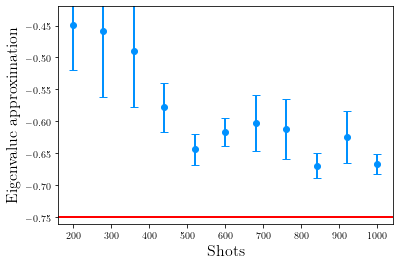

In [49]:
data = QGD_res_proc
fig, ax = plt.subplots()
ax.set_ylim([-0.76, -0.42])
ax.errorbar(x = x_coor, y = data['mean'],\
            yerr=data['sem'], fmt='o',\
            color='#0091FF', elinewidth = 2, capsize=4,\
            figure = fig)
ax.axline(xy1= [250.0,-0.75], slope = 0, color = 'red', linewidth = 2)
ax.set_xlabel('Shots', fontsize=16)
ax.set_ylabel('Eigenvalue approximation', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('QGD_results.pdf')

Text(0, 0.5, 'Evaluations')

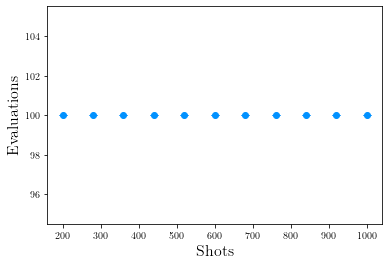

In [50]:
data = QGD_nfev_proc
fig, ax = plt.subplots()
ax.errorbar(x = x_coor, y = data['mean'],\
            yerr=data['sem'], fmt='o',\
            color='#0091FF', elinewidth = 2, capsize=4,\
            figure = fig)
ax.set_xlabel('Shots', fontsize=16)
ax.set_ylabel('Evaluations', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('QGD_nfev.pdf')

In [46]:
data = [QGD_res_proc,QGD_nfev_proc]
data_names = ['QGD_res_proc','QGD_nfev_proc']
for it in range(2):
    data[it].style.to_latex(data_names[it]+'.tex')

In [54]:
QSPSA_results = []
QSPSA_nfev = []
for SHOTS in range(200, 1040, 80):
    res_tmp = []
    nfev_tmp = []
    for it in range(10): 
        print('-------------- SHOTS =',SHOTS,' it=',it,'--------------')
        qinstance_tmp = QuantumInstance(backend, shots = SHOTS)
        vqe_tmp = VQE(ansatz=QC, initial_point = [1.0, 1.0, 1.0, 1.0],\
                      optimizer=SPSA(maxiter=100,\
                      tol=0.01), quantum_instance=qinstance_tmp,\
                      expectation=PauliExpectation())
        result_tmp = vqe_tmp.compute_minimum_eigenvalue(H_op)
        res_tmp.append(result_tmp.eigenvalue.real)
        nfev_tmp.append(result_tmp.cost_function_evals)
    QSPSA_results.append(res_tmp)
    QSPSA_nfev.append(nfev_tmp)
QSPSA_results_df = pd.DataFrame(QSPSA_results)
QSPSA_nfev_df = pd.DataFrame(QSPSA_nfev)
QSPSA_results_df.to_csv("QSPSA_results_df.csv", index=False)
QSPSA_nfev_df.to_csv("QSPSA_nfev_df.csv", index=False)
QSPSA_res_proc = pd_process(QSPSA_results_df)
QSPSA_nfev_proc = pd_process(QSPSA_nfev_df)

-------------- SHOTS = 200  it= 0 --------------


TypeError: __init__() got an unexpected keyword argument 'tol'

### Project original implementations

In [71]:
def add_HEA(parameters, circuit):
    p = int(len(parameters)/2)
    beta = parameters[:p]
    gamma = parameters[p:]
    for it in range(0,len(beta)):
        circuit.rx(beta[it], it)
    for it in range(0,len(gamma)):
        circuit.ry(gamma[it], it)
    for i in range(0,len(beta)-1):
        circuit.cx(i, i+1)

def run_vqe(parameters, layers, hamiltonian_op, shots):
    NQUBITS = int(len(parameters)/2)
    # Create quantum circuit
    QC = QuantumCircuit(NQUBITS)
    add_HEA(parameters,QC)
    #simulator=Aer.get_backend('aer_simulator', device='GPU')
    simulator=Aer.get_backend('qasm_simulator')
    qi = QuantumInstance(simulator, shots = shots)
    #exp_converter = ExpectationFactory.build(hamiltonian_op, qi)
    measurable_expression =  ~StateFn(hamiltonian_op) @ StateFn(QC)
    #expect_op = exp_converter.convert(measurable_expression)
    expect_op = PauliExpectation().convert(measurable_expression)
    sampled_op = CircuitSampler(qi).convert(expect_op)
    expectation_value = sampled_op.eval().real
    return expectation_value

In [306]:
# Basic implemenation of the simple gradient descent 
def gradient_descent(GRADIENT_FUN, INITIAL, ETA, MAX_ITER=100, EPSILON=0.05):
    vector = np.array(INITIAL).copy()
    learning_rate = ETA
    step = 0.05
    loops = 0
    for i in range(0, MAX_ITER):
        GRAD = GRADIENT_FUN(vector, step)
        #print(GRAD)
        diff = - learning_rate * np.array(GRAD)
        if np.all(np.abs(diff) <= EPSILON):
            break
        vector += diff
        #for index in range(0, len(vector)):
        #    if np.abs(vector[index]) > 3.15/2:
        #        vector[index] /= 2
        #step /= 1.01
        loops += 1
        #print(vector)
    return vector.tolist(), loops
#RMSProp
def RMSProp(GRADIENT_FUN, INITIAL, ETA, GAM, MAX_ITER=100, EPSILON=0.05):
    vector = np.array(INITIAL)
    learning_rate = ETA
    avg_par = GAM
    step = 0.05
    loops = 0
    e_small = 0.01
    LEN = len(INITIAL)
    E = []
    for j in range(0,LEN):
        E.append(0)
    for i in range(0, MAX_ITER):
        GRAD = GRADIENT_FUN(vector, step)
        diff = []
        for j in range(0, LEN):
            E[j] = avg_par * E[j] + (1-avg_par)*(GRAD[j]**2)
            diff.append(- (learning_rate/(np.sqrt(E[j])+e_small)) * GRAD[j])
        if np.all(np.abs(diff) <= EPSILON):
            break
        vector += diff
        for index in range(0, len(vector)):
            if np.abs(vector[index]) > 3.15/2:
                vector[index] /= 2
        #step = (np.abs(diff).sum()/LEN)/2
        loops += 1
    return vector.tolist(), loops

# FDSA calculation of gradient
def gradient(point, step, obj_fun):
    grad = []
    for j in range(0,len(point)):
        point_plus = point.copy()
        point_minus = point.copy()
        point_plus[j] = point_plus[j] + step
        point_minus[j] -= step
        plus = (obj_fun(point_plus))
        minus = (obj_fun(point_minus))
        grad.append((plus-minus)/(2*step))
    return grad

# helper functions
def get_run_vqe(layers, hamiltonian_op, shots):
    def runner(parameters):
        return run_vqe(parameters, layers, hamiltonian_op, shots)
    return runner

def get_gradient_vqe(layers, hamiltonian_op, shots=512):
    obj = get_run_vqe(layers, hamiltonian_op, shots)
    def nabla(point, step):
        return gradient(point, step, obj)
    return nabla


### Simple gradient descent without scheduling

In [147]:
#seed = 50
GRAD = get_gradient_vqe(1, H_op, 1000)
result1, num_loops = gradient_descent(GRAD, [0.0,0.0,0.0,0.0], 0.045, EPSILON=0.01)

In [148]:
print('Result parameters', result1)
print('Number of gradient calls', num_loops)

Result parameters [-0.04364999999999994, -0.0179999999999998, 0.004275000000000259, 0.7844625]
Number of gradient calls 34


In [150]:
for _ in range(10):
    print('Ground state approximation: ', run_vqe(result1,1, H_op, 10000))

Ground state approximation:  -0.39052499999999984
Ground state approximation:  -0.39160000000000006
Ground state approximation:  -0.390675
Ground state approximation:  -0.38570000000000004
Ground state approximation:  -0.3828750000000001
Ground state approximation:  -0.39297500000000013
Ground state approximation:  -0.3851000000000001
Ground state approximation:  -0.3864000000000001
Ground state approximation:  -0.38720000000000004
Ground state approximation:  -0.38675000000000004


Old

In [87]:
print('Ground state approximation: ', run_vqe(result1,1, H_op, 400))

Ground state approximation:  -0.596875


### RMSProp optimization

In [298]:
GRAD = get_gradient_vqe(1, H_op, 1000)
result3, num_loops = RMSProp(GRAD, [0.0,0.0,0.0,0.0], 0.15, 0.8 , 100, EPSILON=0.073)

E [0.02012461 0.1185116  0.0067082  0.27503636]
diff [0.22406927748561256, 0.3093105924415692, -0.1346643845795773, 0.32364291910378895]
E [0.14423592 0.18261229 0.05288903 0.31501746]
diff [-0.3112115560822775, 0.25893985740723363, 0.2802555336005768, 0.2030660138498237]
E [0.13514141 0.17058077 0.0505747  0.31064457]
diff [-0.09301274005665482, 0.09137185403126998, -0.09905125859938343, 0.13683375256045566]
E [0.18647201 0.23257147 0.07018718 0.32865071]
diff [-0.2424009421683968, -0.24271196979481086, -0.2244747898349173, 0.17385169452041752]
E [0.17486766 0.26790454 0.08332012 0.30758784]
diff [0.09533847153192465, -0.2037570174641499, -0.19690288084582386, 0.09564282934350139]
E [0.17694055 0.29441386 0.09733341 0.42012882]
diff [0.148442913699004, -0.1884769607894939, 0.19565202575492918, 0.2476002420378904]
E [0.17858154 0.28072205 0.09077601 0.39368494]
diff [-0.14715119984710073, 0.11222059040648064, -0.08558584112587608, 0.09753893763330955]
E [0.16029065 0.2533158  0.2942846

In [299]:
print('Result parameters', result3)
print('Number of gradient calls', num_loops)

Result parameters [0.02849161057220069, 0.3852881508950188, 0.3464457766742616, 1.4841117118016527]
Number of gradient calls 30


In [302]:
print('Ground state approximation: ', run_vqe(result3,1, H_op, 1000))

Ground state approximation:  -0.6045


Text(0, 0.5, 'Y')

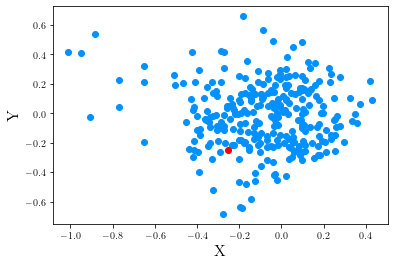

In [303]:
a = [0.31995667]
b = [-0.25197738]
fig, ax = plt.subplots()
ax.scatter(x = X, y = Y,\
            color='#0091FF',\
            figure = fig)
ax.scatter(x = b, y = b,\
            color='red',\
            figure = fig)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)
#ax.set_title('COBYLA approximation')

In [292]:
for _ in range(10):
    print('Ground state approximation: ', run_vqe(result3,1, H_op, 1000))

Ground state approximation:  -0.6084999999999999
Ground state approximation:  -0.60575
Ground state approximation:  -0.6125
Ground state approximation:  -0.5975
Ground state approximation:  -0.6257499999999999
Ground state approximation:  -0.628
Ground state approximation:  -0.6084999999999999
Ground state approximation:  -0.60225
Ground state approximation:  -0.5965
Ground state approximation:  -0.6147500000000001


In [304]:
RMSProp_results = []
RMSProp_nfev = []

In [307]:
for SHOTS in range(200, 1040, 80):
    res_tmp = []
    nfev_tmp = []
    for it in range(10): 
        print('-------------- SHOTS =',SHOTS,' it=',it,'--------------')
        GRAD_tmp = get_gradient_vqe(1, H_op, SHOTS)
        result_tmp, num_loops = RMSProp(GRAD, [0.0,0.0,0.0,0.0], 0.15, 0.8 , 100, EPSILON=0.073)
        res_tmp.append(result_tmp)
        nfev_tmp.append(num_loops)
    RMSProp_results.append(res_tmp)
    RMSProp_nfev.append(nfev_tmp)

-------------- SHOTS = 200  it= 0 --------------
-------------- SHOTS = 200  it= 1 --------------
-------------- SHOTS = 200  it= 2 --------------
-------------- SHOTS = 200  it= 3 --------------
-------------- SHOTS = 200  it= 4 --------------
-------------- SHOTS = 200  it= 5 --------------
-------------- SHOTS = 200  it= 6 --------------
-------------- SHOTS = 200  it= 7 --------------
-------------- SHOTS = 200  it= 8 --------------
-------------- SHOTS = 200  it= 9 --------------
-------------- SHOTS = 280  it= 0 --------------
-------------- SHOTS = 280  it= 1 --------------
-------------- SHOTS = 280  it= 2 --------------
-------------- SHOTS = 280  it= 3 --------------
-------------- SHOTS = 280  it= 4 --------------
-------------- SHOTS = 280  it= 5 --------------
-------------- SHOTS = 280  it= 6 --------------
-------------- SHOTS = 280  it= 7 --------------
-------------- SHOTS = 280  it= 8 --------------
-------------- SHOTS = 280  it= 9 --------------
-------------- SHOTS

In [308]:
RMSProp_results_df = pd.DataFrame(RMSProp_results)
RMSProp_nfev_df = pd.DataFrame(RMSProp_nfev)

In [364]:
from ast import literal_eval
for i in range(11):
    for j in range(10):
        RMSProp_results_df.iloc[i,j] = run_vqe(literal_eval(RMSProp_results_df.iloc[i,j]),1, H_op, 1000)

In [372]:
RMSProp_results_df.to_csv("RMSProp_results_df.csv", index=False)

In [363]:
RMSProp_results_df = pd.read_csv('RMSProp_results_df.csv')

In [310]:
RMSProp_nfev_df.to_csv("RMSProp_nfev_df.csv", index=False)

In [366]:
RMSProp_res_proc = pd_process(RMSProp_results_df)

In [367]:
RMSProp_nfev_proc = pd_process(RMSProp_nfev_df)

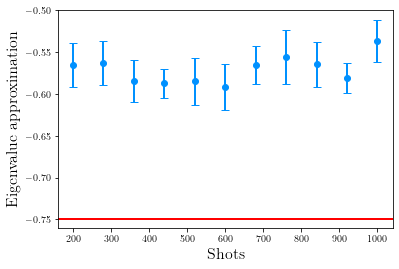

In [370]:
data = RMSProp_res_proc
fig, ax = plt.subplots()
ax.set_ylim([-0.76, -0.5])
ax.errorbar(x = x_coor, y = data['mean'],\
            yerr=data['sem'], fmt='o',\
            color='#0091FF', elinewidth = 2, capsize=4,\
            figure = fig)
ax.axline(xy1= [250.0,-0.75], slope = 0, color = 'red', linewidth = 2)
ax.set_xlabel('Shots', fontsize=16)
ax.set_ylabel('Eigenvalue approximation', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('RMSProp_results.pdf')

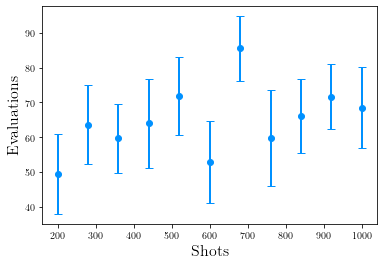

In [375]:
data = RMSProp_nfev_proc
fig, ax = plt.subplots()
ax.errorbar(x = x_coor, y = data['mean'],\
            yerr=data['sem'], fmt='o',\
            color='#0091FF', elinewidth = 2, capsize=4,\
            figure = fig)
ax.set_xlabel('Shots', fontsize=16)
ax.set_ylabel('Evaluations', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('RMSProp_nfev.pdf')

### Gradient-free optimizer

In [264]:
CIRC = get_run_vqe(1, H_op, 300)
result4 = minimize(CIRC, [-1.0, -1.0, -1.0, -1.0], method='COBYLA', tol=0.0001)
# result4 is not an array!
result4

     fun: -0.7041666666666666
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 55
  status: 1
 success: True
       x: array([ 0.31995667, -0.25197738,  0.69652048,  2.1600795 ])

In [265]:
print('Ground state approximation: ', result4.fun)

Ground state approximation:  -0.7041666666666666


In [2]:
COBYLA_results = []
COBYLA_nfev = []

In [50]:
for SHOTS in range(200, 1040, 80):
    res_tmp = []
    nfev_tmp = []
    for it in range(10): 
        print('-------------- SHOTS =',SHOTS,' it=',it,'--------------')
        CIRC_tmp = get_run_vqe(1, H_op, SHOTS)
        result_tmp = minimize(CIRC_tmp, [1.0, 1.0, 1.0, 1.0], method='COBYLA', tol=0.0001)
        res_tmp.append(result_tmp.fun)
        nfev_tmp.append(result_tmp.nfev)
    COBYLA_results.append(res_tmp)
    COBYLA_nfev.append(nfev_tmp)

-------------- SHOTS = 200  it= 0 --------------
-------------- SHOTS = 200  it= 1 --------------
-------------- SHOTS = 200  it= 2 --------------
-------------- SHOTS = 200  it= 3 --------------
-------------- SHOTS = 200  it= 4 --------------
-------------- SHOTS = 200  it= 5 --------------
-------------- SHOTS = 200  it= 6 --------------
-------------- SHOTS = 200  it= 7 --------------
-------------- SHOTS = 200  it= 8 --------------
-------------- SHOTS = 200  it= 9 --------------
-------------- SHOTS = 280  it= 0 --------------
-------------- SHOTS = 280  it= 1 --------------
-------------- SHOTS = 280  it= 2 --------------
-------------- SHOTS = 280  it= 3 --------------
-------------- SHOTS = 280  it= 4 --------------
-------------- SHOTS = 280  it= 5 --------------
-------------- SHOTS = 280  it= 6 --------------
-------------- SHOTS = 280  it= 7 --------------
-------------- SHOTS = 280  it= 8 --------------
-------------- SHOTS = 280  it= 9 --------------
-------------- SHOTS

Save results and load

In [53]:
COBYLA_results_df = pd.DataFrame(COBYLA_results)
COBYLA_nfev_df = pd.DataFrame(COBYLA_nfev)

In [55]:
COBYLA_results_df.to_csv("COBYLA_results_df.csv", index=False)

In [56]:
COBYLA_nfev_df.to_csv("COBYLA_nfev_df.csv", index=False)

## Processing and output

In [4]:
COBYLA_results_df = pd.read_csv("COBYLA_results_df.csv")

In [6]:
COBYLA_nfev_df = pd.read_csv("COBYLA_nfev_df.csv")

In [29]:
COBYLA_res_proc = pd_process(COBYLA_results_df)
COBYLA_nfev_proc = pd_process(COBYLA_nfev_df)

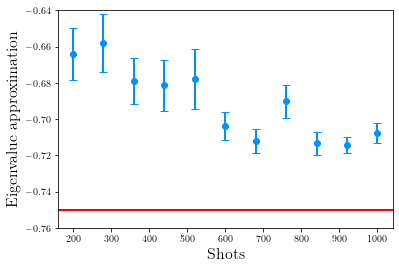

In [57]:
data = COBYLA_res_proc
fig, ax = plt.subplots()
ax.set_ylim([-0.76, -0.64])
ax.errorbar(x = x_coor, y = data['mean'],\
            yerr=data['sem'], fmt='o',\
            color='#0091FF', elinewidth = 2, capsize=4,\
            figure = fig)
ax.axline(xy1= [250.0,-0.75], slope = 0, color = 'red', linewidth = 2)
ax.set_xlabel('Shots', fontsize=16)
ax.set_ylabel('Eigenvalue approximation', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('COBYLA_results.pdf')

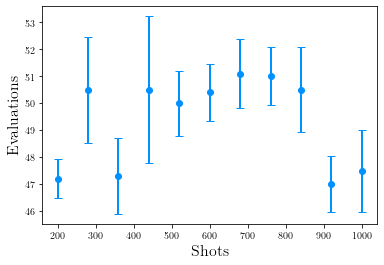

In [74]:
data = COBYLA_nfev_proc
fig, ax = plt.subplots()
ax.errorbar(x = x_coor, y = data['mean'],\
            yerr=data['sem'], fmt='o',\
            color='#0091FF', elinewidth = 2, capsize=4,\
            figure = fig)
ax.set_xlabel('Shots', fontsize=16)
ax.set_ylabel('Evaluations', fontsize=16)
#ax.set_title('COBYLA approximation')
plt.savefig('COBYLA_nfev.pdf')

In [374]:
data = [RMSProp_res_proc,RMSProp_nfev_proc,COBYLA_res_proc,COBYLA_nfev_proc]
data_names = ['RMSProp_res_proc','RMSProp_nfev_proc','COBYLA_res_proc','COBYLA_nfev_proc']
for it in range(4):
    data[it].style.to_latex(data_names[it]+'.tex')

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table